In [1]:
import functools
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm
from ott.neural.networks.layers import time_encoder
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

from ot_pert.metrics import compute_mean_metrics, compute_metrics_fast
from ot_pert.nets.nets import CondVelocityField
from ot_pert.utils import ConditionalLoader

In [2]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/satija_ifng/adata_train_ifng.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/satija_ifng/adata_test_ifng.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/satija_ifng/adata_ood_ifng.h5ad"

In [3]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [13]:
adata_train.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,cell_type,percent.mito,sample_ID,Batch_info,bc1_well,bc2_well,bc3_well,guide,gene,mixscale_score,condition,ood,is_ood,split
28_60_96_1_1_1_1_1_1_1_1_1,28,15714.0,5337,BXCP3_IFNG,BXPC3,8.120148,sample_1,Rep1,nan,nan,nan,IRF9g3,IRF9,0.469935,BXPC3_IRF9,False,False,train
27_12_66_1_1_1_1_1_1_1_1_1,27,14031.0,5169,BXCP3_IFNG,BXPC3,2.202266,sample_1,Rep1,nan,nan,nan,TRAFD1g1,TRAFD1,-0.324546,BXPC3_TRAFD1,False,False,train
25_18_07_1_1_1_1_1_1_1_1_1,25,13473.0,4874,BXCP3_IFNG,BXPC3,1.261783,sample_1,Rep1,nan,nan,nan,PRDM1g1,PRDM1,-0.444882,BXPC3_PRDM1,False,False,train
28_15_49_1_1_1_1_1_1_1_1_1,28,12256.0,4183,BXCP3_IFNG,BXPC3,5.572781,sample_1,Rep1,nan,nan,nan,FOXN3g1,FOXN3,0.198721,BXPC3_FOXN3,False,False,train
25_76_28_1_1_1_1_1_1_1_1_1,25,11595.0,4862,BXCP3_IFNG,BXPC3,2.673566,sample_1,Rep1,nan,nan,nan,PTPN11g2,PTPN11,1.399306,BXPC3_PTPN11,False,False,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21_25_62_2_2,21,940.0,769,BXPC3_IFNG,BXPC3,5.851064,sample_16,Rep2,B9,C1,F2,PARP12g1,PARP12,0.321505,BXPC3_PARP12,False,False,train
23_57_15_2_2,23,935.0,722,BXPC3_IFNG,BXPC3,3.422460,sample_16,Rep2,B11,E9,B3,PRDM1g1,PRDM1,0.509836,BXPC3_PRDM1,False,False,train
21_67_17_2_2,21,932.0,702,BXPC3_IFNG,BXPC3,2.038627,sample_16,Rep2,B9,F7,B5,TRAFD1g1,TRAFD1,0.074617,BXPC3_TRAFD1,False,False,train
23_89_89_2_2,23,890.0,671,BXPC3_IFNG,BXPC3,10.786517,sample_16,Rep2,B11,H5,H5,RUNX1g2,RUNX1,1.333320,BXPC3_RUNX1,False,False,train


In [ ]:
control = "BXPC3_NT"

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


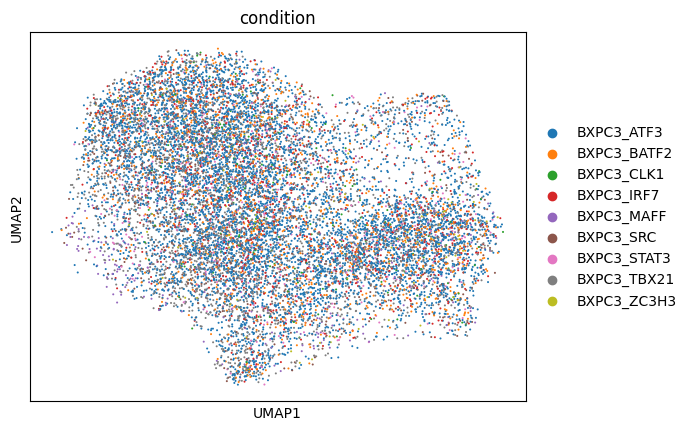

In [17]:
sc.pl.umap(adata_ood, color="condition")

In [22]:
adata_train.obsm["cond_emb"].shape

(47176, 2860)

In [23]:
adata_train.obsm["cell_line_emb"].shape

(47176, 300)

In [25]:
adata_train.obsm["gene_emb"].shape

(47176, 2560)

In [26]:
obsm_key_cond = "cond_emb"
obsm_key_data = "X_pca"

In [27]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
    epsilon: float = 1e-2,
    tau_a: float = 1.0,
    tau_b: float = 1.0,
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(
            x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b
        )
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
    raise NotImplementedError(f"Unknown type: {typ}.")


# Load data

dls = []

train_data_source = {}
train_data_target = {}
train_data_source_decoded = {}
train_data_target_decoded = {}
train_data_conditions = {}


for cond in adata_train.obs["condition"].cat.categories:
    source = adata_train[adata_train.obs["condition"] == "BXPC3_NT"].obsm[obsm_key_data]
    source_decoded = adata_train[adata_train.obs["condition"] == "BXPC3_NT"].X.A
    if cond == "BXPC3_NT":
        continue
    target = adata_train[adata_train.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_train[adata_train.obs["condition"] == cond].X.A
    conds = adata_train[adata_train.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    dls.append(
        DataLoader(
            datasets.OTDataset(
                datasets.OTData(
                    lin=source,
                    condition=conds,
                ),
                datasets.OTData(lin=target),
            ),
            batch_size=1024,
            shuffle=True,
        )
    )
    train_data_source[cond] = source
    train_data_target[cond] = target
    train_data_conditions[cond] = conds
    train_data_source_decoded[cond] = source_decoded
    train_data_target_decoded[cond] = target_decoded

train_loader = ConditionalLoader(dls, seed=0)

2024-04-24 15:56:39.590478: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [30]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add


reconstruct_data_fn = functools.partial(
    reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
)


def get_mask(x, y):
    return x[:, [gene in y for gene in adata_train.var_names]]

In [31]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

In [32]:
from typing import Optional

import jax.numpy as jnp

In [33]:
vf = CondVelocityField(
    hidden_dims=[1024, 1024, 1024],
    time_dims=[512, 512],
    output_dims=[1024, 1024, 1024] + [target_dim],
    condition_dims=[2048, 2048, 2048],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    dropout_rate=0.1,
)

model = otfm.OTFlowMatching(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.1),
    match_fn=jax.jit(
        functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None, epsilon=0.1, tau_a=1.0, tau_b=1.0)
    ),
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),
)

training_logs = {"loss": []}

In [42]:
rng = jax.random.PRNGKey(0)
for it in tqdm(range(10000)):
    rng, rng_resample, rng_step_fn = jax.random.split(rng, 3)
    batch = next(train_loader)
    batch = jtu.tree_map(jnp.asarray, batch)

    src, tgt = batch["src_lin"], batch["tgt_lin"]
    src_cond = batch.get("src_condition")

    if model.match_fn is not None:
        tmat = model.match_fn(src, tgt)
        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        src, tgt = src[src_ixs], tgt[tgt_ixs]
        src_cond = None if src_cond is None else src_cond[src_ixs]

    model.vf_state, loss = model.step_fn(
        rng_step_fn,
        model.vf_state,
        src,
        tgt,
        src_cond,
    )

    training_logs["loss"].append(float(loss))
    if (it % 100000 == 0) and (it > 0):
        idcs = np.random.choice(list(test_data_source.keys()), 20)
        test_data_source_tmp = {k: v for k, v in test_data_source.items() if k in idcs}
        test_data_target_tmp = {k: v for k, v in test_data_target.items() if k in idcs}
        test_data_conditions_tmp = {k: v for k, v in test_data_conditions.items() if k in idcs}
        test_data_target_decoded_tmp = {k: v for k, v in test_data_target_decoded.items() if k in idcs}
        test_deg_dict_tmp = {k: v for k, v in test_deg_dict.items() if k in idcs}
        valid_losses = []
        # for cond in test_data_source_tmp.keys():
        #    src = test_data_source_tmp[cond]
        #    tgt = test_data_target_tmp[cond]
        #    src_cond = test_data_conditions_tmp[cond]
        #    if model.match_fn is not None:
        #        tmat = model.match_fn(src, tgt)
        #        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        #        src, tgt = src[src_ixs], tgt[tgt_ixs]
        #        src_cond = None if src_cond is None else src_cond[src_ixs]
        #    _, valid_loss = model.step_fn(
        #        rng,
        #        model.vf_state,
        #        src,
        #        tgt,
        #        src_cond,
        #    )
        #    valid_losses.append(valid_loss)

        # predicted_target_train = jax.tree_util.tree_map(model.transport, train_data_source, train_data_conditions)
        # train_metrics = jax.tree_util.tree_map(compute_metrics_fast, train_data_target, predicted_target_train)
        # mean_train_metrics = compute_mean_metrics(train_metrics, prefix="train_")

        # predicted_target_train_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_train)
        # train_metrics_decoded = jax.tree_util.tree_map(compute_metrics_fast, train_data_target_decoded, predicted_target_train_decoded)
        # mean_train_metrics_decoded = compute_mean_metrics(train_metrics_decoded, prefix="decoded_train_")

        # train_deg_target_decoded_predicted = jax.tree_util.tree_map(get_mask, predicted_target_train_decoded, train_deg_dict)
        # train_deg_target_decoded = jax.tree_util.tree_map(get_mask, train_data_target_decoded, test_deg_dict)

        # predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tmp, test_data_conditions_tmp)
        # test_metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target_tmp, predicted_target_test)
        # mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")

        # predicted_target_test_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_test)
        # test_metrics_decoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, test_data_target_decoded_tmp, predicted_target_test_decoded
        # )
        # mean_test_metrics_decoded = compute_mean_metrics(test_metrics_decoded, prefix="decoded_test_")

        # test_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_test_decoded, test_deg_dict_tmp
        # )
        # test_deg_target_decoded = jax.tree_util.tree_map(get_mask, test_data_target_decoded_tmp, test_deg_dict_tmp)
        # deg_test_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, test_deg_target_decoded, test_deg_target_decoded_predicted
        # )
        # deg_mean_test_metrics_encoded = compute_mean_metrics(deg_test_metrics_encoded, prefix="deg_test_")

        predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
        ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
        mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

        predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
        ood_metrics_decoded = jax.tree_util.tree_map(
            compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
        )
        mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

        # ood_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_ood_decoded, ood_deg_dict
        # )
        # ood_deg_target_decoded = jax.tree_util.tree_map(get_mask, ood_data_target_decoded, ood_deg_dict)
        # deg_ood_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, ood_deg_target_decoded, ood_deg_target_decoded_predicted
        # )
        # deg_mean_ood_metrics_encoded = compute_mean_metrics(deg_ood_metrics_encoded, prefix="deg_ood_")
        print(mean_test_metrics_decoded, mean_ood_metrics_decoded)

 80%|███████▉  | 7986/10000 [18:23<02:47, 12.01it/s]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 10000/10000 [22:36<00:00,  7.37it/s]


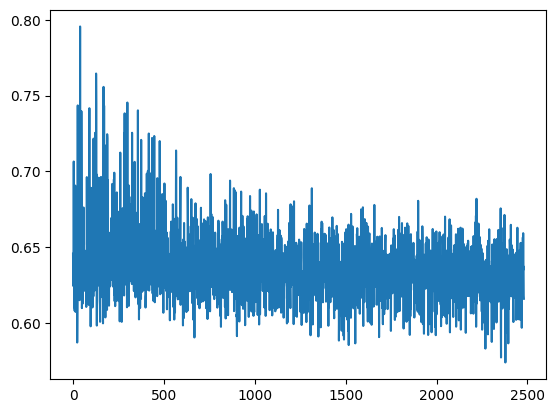

In [35]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(training_logs["loss"])), training_logs["loss"])

In [36]:
test_data_source = {}
test_data_target = {}
test_data_source_decoded = {}
test_data_target_decoded = {}
test_data_conditions = {}

for cond in adata_test.obs["condition"].cat.categories:
    source = adata_test[adata_test.obs["condition"] == "BXPC3_NT"].obsm[obsm_key_data]
    source_decoded = adata_test[adata_test.obs["condition"] == "BXPC3_NT"].X.A
    if cond == "BXPC3_NT":
        continue

    target = adata_test[adata_test.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_test[adata_test.obs["condition"] == cond].X.A

    conds = adata_test[adata_test.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_source_decoded[cond] = source_decoded
    test_data_target_decoded[cond] = target_decoded
    test_data_conditions[cond] = conds

ood_data_source = {}
ood_data_target = {}
ood_data_source_decoded = {}
ood_data_target_decoded = {}
ood_data_conditions = {}

for cond in adata_ood.obs["condition"].cat.categories:
    source = adata_ood[adata_ood.obs["condition"] == "BXPC3_NT"].obsm[obsm_key_data]
    source_decoded = adata_ood[adata_ood.obs["condition"] == "BXPC3_NT"].X.A
    if cond == "BXPC3_NT":
        continue

    target = adata_ood[adata_ood.obs["condition"] == cond].obsm[obsm_key_data]
    target_decoded = adata_ood[adata_ood.obs["condition"] == cond].X.A
    conds = adata_ood[adata_ood.obs["condition"] == cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_source_decoded[cond] = source_decoded
    ood_data_target_decoded[cond] = target_decoded
    ood_data_conditions[cond] = conds

In [37]:
predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source, test_data_conditions)
test_metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target, predicted_target_test)
mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")

predicted_target_test_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_test)
test_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, test_data_target_decoded, predicted_target_test_decoded
)
mean_test_metrics_decoded = compute_mean_metrics(test_metrics_decoded, prefix="decoded_test_")

In [38]:
mean_test_metrics_decoded

{'decoded_test_r_squared': 0.9552654806797561,
 'decoded_test_e_distance': 4.818839355035442,
 'decoded_test_mmd_distance': 0.06979140624490233}

In [41]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)

ValueError: zero-size array to reduction operation max which has no identity

In [40]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

ValueError: zero-size array to reduction operation max which has no identity

In [ ]:
mean_ood_metrics_decoded

In [ ]:
mean_ood_metrics

In [69]:
embs = jax.tree_util.tree_map(lambda x: vf.get_embedding(model.vf_state, x[0:1]), ood_data_conditions)

In [71]:
embs_arr = np.concatenate(embs_ls, axis=0)

In [77]:
emb = embs_arr

In [78]:
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity

In [79]:
similarity_matrix = cosine_similarity(emb)
np.fill_diagonal(similarity_matrix, 1.0)
X = KernelPCA(n_components=2, kernel="precomputed").fit_transform(similarity_matrix)

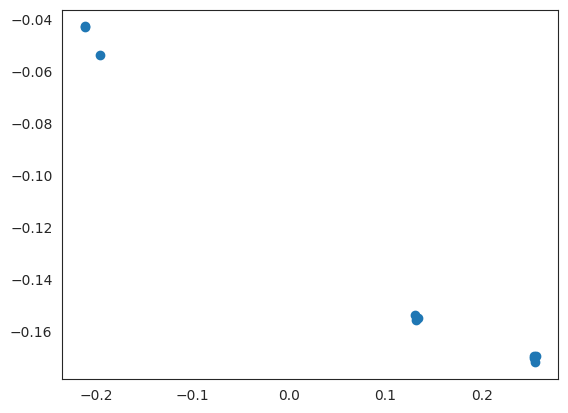

In [87]:
plt.scatter(X[:10, 0], X[:10, 1])

In [91]:
from ot_pert.plotting import plot_embedding

In [95]:
df_conditions["dose"].unique()

[10.0, 100.0, 10000.0, 1000.0]
Categories (4, float64): [10.0, 100.0, 1000.0, 10000.0]

In [97]:
def get_dose_color(x):
    dose = x["dose"]
    if dose == 10.0:
        return "#f7e5e4"
    if dose == 100.0:
        return "#f29f99"
    if dose == 1000.0:
        return "#f5675d"
    if dose == 10000.0:
        return "#f01405"


df_conditions["dose_color"] = df_conditions.apply(get_dose_color, axis=1)

In [98]:
col_dict_dose = df_conditions.set_index("condition")["dose_color"].to_dict()

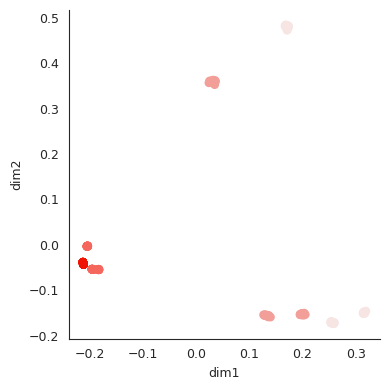

In [100]:
plot_embedding(X, labels=np.array(list(embs.keys())), show_text=False, col_dict=col_dict_dose)

In [102]:
def get_cell_line_color(x):
    cell_line = x["cell_line"]
    if cell_line == "MCF7":
        return "#38f005"
    if cell_line == "K562":
        return "#cc05f0"
    if cell_line == "A549":
        return "#058af0"


df_conditions["cell_line_color"] = df_conditions.apply(get_cell_line_color, axis=1)

In [103]:
col_dict_cell_line = df_conditions.set_index("condition")["cell_line_color"].to_dict()

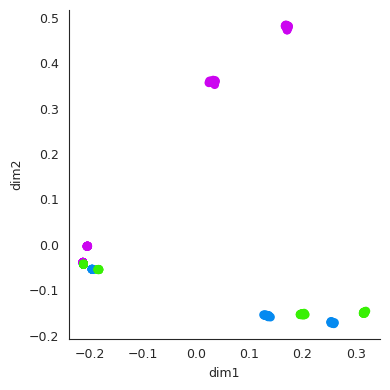

In [104]:
plot_embedding(X, labels=np.array(list(embs.keys())), show_text=False, col_dict=col_dict_cell_line)

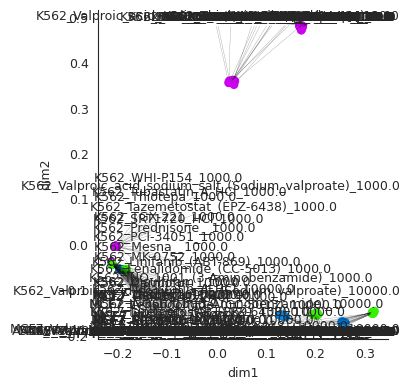

In [105]:
plot_embedding(X, labels=np.array(list(embs.keys())), show_text=True, col_dict=col_dict_cell_line)